# Language detection #
### Команда: ###
* Анна Лапидус
* Анастасия Кузнецова
* Надежда Катричева
* Альфия Бабий

(Сначала мы взялись делать вариант В задания, но походу решения задач этого варианта, мы почувствовали в себе желание обучить классификатор, поэтому в нашей выборке для классификатора оказалось 7 языков.)

# Список языков#

* Английский
* Испанский
* Португальский
* Индонезийский 
* Литовский 
* Польский
* Чешский

## Скачиваем статьи из Википедии ##

In [1]:
import wikipedia

In [2]:
wikipedia.set_lang("en")

In [3]:
random_pages_names = wikipedia.random(pages=3)

In [4]:
for random_name in random_pages_names:
    page_text = []
    random_name = wikipedia.search(random_name)
    saved_page = wikipedia.page(random_name[0])
    try:
        page_text.append(saved_page.title)
        page_text.append(saved_page.summary)
        page_text.append(saved_page.content)
    except wikipedia.exceptions.DisambiguationError as e:
        print("Error: {0}".format(e))
             
   
    page_text = ' '.join(page_text)

    file_name = ((saved_page.title) + '.txt')

    with open(file_name, 'w') as fl:
        fl.write(page_text)

# Препроцессинг #

## Общие замечания: ##

* Для удобства работы с текстами необходимо приведение к нижнему регистру;
* Удаление знаков препинания;
* Удаление цифр;
* Названия рубрик в статьях Википедии (они присутствуют в каждой статье), все рубрики выделяются аналогичным образом для всех языков: == Название ==;
* Удалить все после обозначения рубрики “Ссылки” (References), т.к. часто они ссылаются на источники на других языках.
* Существуют тексты с большим количеством аббревиатур. Эти слова оказываются частотными в нашей коллекции и добавляют не нужные  для рассмотрения токены.

## Особые случаи предобработки отдельных языков ##

* *Индонезийский язык:* присутствует гортанная смычка в конце некоторых слов в виде апострофов, она является значимой частью слова, но поскольку мы будем обрабатывать n-граммы, а не слова, и апостроф будет давать лишний уникальный символ для этого языка, мы его не сохраняем. 
* *Английский язык:* оказывается частотным 's от притяжательных местоимений, удалим его при предобработке.
* *Литовский язык:* необходимо учесть особый формат даты при предобработке, поскольку он повлияет на список частотных n-грамм. 

In [5]:
import os
import re

In [6]:
id_wiki_texts = []
for root, dirs, files in os.walk(r'/home/nst/mount/data/share/yd/comp_ling/HW1/extracted_lang_data/id'):
    for fname in files:
        with open(root + '/' + fname, encoding = 'utf-8') as fo:
            id_wiki_texts.append(fo.read())

In [7]:
pt_wiki_texts = []
for root, dirs, files in os.walk(r'/home/nst/mount/data/share/yd/comp_ling/HW1/extracted_lang_data/pt'):
    for fname in files:
        with open(root + '/' + fname, encoding = 'utf-8') as fo:
            pt_wiki_texts.append(fo.read())

In [8]:
pl_wiki_texts = []
for root, dirs, files in os.walk(r'/home/nst/mount/data/share/yd/comp_ling/HW1/extracted_lang_data/pl'):
    for fname in files:
        with open(root + '/' + fname, encoding = 'utf-8') as fo:
            pl_wiki_texts.append(fo.read())

In [9]:
cs_wiki_texts = []
for root, dirs, files in os.walk(r'/home/nst/mount/data/share/yd/comp_ling/HW1/extracted_lang_data/cs'):
    for fname in files:
        with open(root + '/' + fname, encoding = 'utf-8') as fo:
            cs_wiki_texts.append(fo.read())

In [10]:
lt_wiki_texts = []
for root, dirs, files in os.walk(r'/home/nst/mount/data/share/yd/comp_ling/HW1/extracted_lang_data/lt'):
    for fname in files:
        with open(root + '/' + fname, encoding = 'utf-8') as fo:
            lt_wiki_texts.append(fo.read())

In [11]:
es_wiki_texts = []
for root, dirs, files in os.walk(r'/home/nst/mount/data/share/yd/comp_ling/HW1/extracted_lang_data/es'):
    for fname in files:
        with open(root + '/' + fname, encoding = 'utf-8') as fo:
            es_wiki_texts.append(fo.read())

In [12]:
en_wiki_texts = []

for root, dirs, files in os.walk(r'/home/nst/mount/data/share/yd/comp_ling/HW1/extracted_lang_data/en'):
    for fname in files:
        with open(root + '/' + fname, encoding = 'utf-8') as fo:
            en_wiki_texts.append(fo.read())

Учитывая особенности наших языков, мы решили написать общую функцию предобработки для тех, где нет особенностей, которые стоит учитывать при токенизации. С помощью этой функции можно обработать *испанский, португальский, чешский*. Он подойдет также для *польского и литовского* с небольшими изменениями, поскольку в них слово "Ссылка" не похоже на обычное reference или что-то похожее в предыдущих языках. Функция предобработки возвращает список предобработанных текстов.

In [13]:
def preprocess(texts):
    preprocessed_texts_list = []
    for text in texts:
        text = re.sub(r'[A-Z]{2,}', '', text)#убираем аббревиатуры
        lower_text = text.lower()#приводим к нижнему регистру, заменяем тире, чтобы потом оставить дефисы в словах
        #lower_text = re.sub(r'(\d)+-(\d)+','', lower_text)#удаление цифр типа 1999-2001
        del_new_line = re.sub(r'\n', '', lower_text)
        no_ref_text = re.sub(r'== refer(.)+', '', del_new_line)#удаляем все, что после рубрики "Сссылки"
        no_num_text = re.sub(r'\d', '', no_ref_text)#удаляем цифры
        extracted_text = re.findall(r'[\w]+', no_num_text)
        #разделяем на токены - последовательности букв с дефисами
        extracted_text = ' '.join(extracted_text)
        preprocessed_texts_list.append(extracted_text)
    return preprocessed_texts_list

In [14]:
preprocessed_texts_es = preprocess(es_wiki_texts)

In [15]:
preprocessed_texts_pt = preprocess(pt_wiki_texts)


Сделаем небольшие модификации для *литовского* и *польского*.

In [16]:
preprocessed_texts_cs = preprocess(cs_wiki_texts)

In [17]:
def preprocess_pl(texts):
    preprocessed_texts_list = []
    for text in texts:
        text = re.sub(r'[A-Z]{2,}', '', text)#убираем аббревиатуры
        lower_text = text.lower()#.replace(' - ', ' ')
        #lower_text = re.sub(r'(\d)+-(\d)+','', lower_text)
        del_new_line = re.sub(r'\n', '', lower_text)
        no_ref_text = re.sub(r'== przypisy(.)+', '', del_new_line)# ссылка на польском - Przypisy
        no_num_text = re.sub(r'\d', '', no_ref_text)
        extracted_text = re.findall(r'[\w]+', no_num_text)
        extracted_text = ' '.join(extracted_text)
        preprocessed_texts_list.append(extracted_text)
    return preprocessed_texts_list

In [18]:
preprocessed_texts_pl = preprocess_pl(pl_wiki_texts)

В *литовском языке* -  особый формат дат, где слово год "metai" и слово "diena" день сокращаются до m. d. Если их не убрать, то они станут самыми частотными токенами в литовском словаре.                                                      

In [19]:
def prepeocess_lt(texts):
    preprocessed_texts_list = []
    for text in texts:
        text = re.sub(r'[A-Z]{2,}', '', text)#убираем аббревиатуры
        lower_text = text.lower()#.replace(' - ', ' ')
        #lower_text = re.sub(r'(\d)+-(\d)+','', lower_text)
        del_new_line = re.sub(r'\n', '', lower_text)
        no_ref_text = re.sub(r'== nuorodos(.)+', '', del_new_line)#ссылки на литовском
        no_num_text = re.sub(r'\d', '', no_ref_text)
        no_date = re.sub(r'\s\w?(?=\.)', '', no_num_text)
        extracted_text = re.findall(r'[\w]+', no_date)
        extracted_text = ' '.join(extracted_text)
        preprocessed_texts_list.append(extracted_text)
    return preprocessed_texts_list

In [20]:
from collections import Counter

In [21]:
preprocessed_texts_lt = prepeocess_lt(lt_wiki_texts)

## Предобработка индонезийского ##

In [22]:
def preprocess_id(texts):
    preprocessed_texts_list = []
    for text in texts:
        text = re.sub(r'[A-Z]{2,}', '', text)#убираем аббревиатуры
        lower_text = text.lower()#.replace(' - ', ' ')
        #lower_text = re.sub(r'(\d)+-(\d)+','', lower_text)
        del_new_line = re.sub(r'\n', '', lower_text)
        no_ref_text = re.sub(r'== refer(.)+', '', del_new_line)
        no_num_text = re.sub(r'\d', '', no_ref_text)
        extracted_text = re.findall(r'[\w]+', no_num_text)
        extracted_text = ' '.join(extracted_text)
        preprocessed_texts_list.append(extracted_text)
    return preprocessed_texts_list

In [23]:
preprocessed_texts_id = preprocess_id(id_wiki_texts)

## Предобработка английского ##

In [24]:
def preprocess_en(texts):
    preprocessed_texts_list = []
    for text in texts:
        text = re.sub(r'[A-Z]{2,}', '', text)#убираем аббревиатуры 
        lower_text = text.lower().replace('\'s', '')#приводим к нижнему регистру, убираем 's от притяжательных
        del_new_line = re.sub(r'\n', '', lower_text) 
        no_ref_text = re.sub(r'== refer(.)+', '', del_new_line)#удаляем все, что после рубрики "Сссылки"
        no_num_text = re.sub(r'\d', '', no_ref_text)#удаляем цифры
        extracted_text = re.findall(r'[\w]+', no_num_text)#разделяем на токены
        extracted_text = ' '.join(extracted_text)
        preprocessed_texts_list.append(extracted_text)
    return preprocessed_texts_list

In [25]:
preprocessed_texts_en = preprocess_en(en_wiki_texts)

## Векторизация текстов ##

Мы решили сравнивать, а затем классифицировать языки по символьным н-граммам, поскольку среди них есть флективные (падежные языки), что затрудняет обработку и составление частотного словаря.
Составим частотные списки 3-грамм для всех языков.

In [26]:
import pandas as pd

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

In [28]:
vect = CountVectorizer(ngram_range = [3,3], analyzer = 'char_wb', max_features = 300)
vectorized_es = vect.fit_transform(preprocessed_texts_es)
feature_names_es = vect.get_feature_names()

In [29]:
feature_names_es #частотный список для испанского

[' a ',
 ' ac',
 ' al',
 ' an',
 ' ar',
 ' as',
 ' ba',
 ' ca',
 ' ci',
 ' co',
 ' cu',
 ' de',
 ' di',
 ' do',
 ' el',
 ' en',
 ' es',
 ' ex',
 ' fa',
 ' fi',
 ' fu',
 ' gr',
 ' ha',
 ' in',
 ' ju',
 ' la',
 ' li',
 ' lo',
 ' ma',
 ' me',
 ' mi',
 ' mo',
 ' mu',
 ' má',
 ' na',
 ' no',
 ' or',
 ' pa',
 ' pe',
 ' po',
 ' pr',
 ' pu',
 ' qu',
 ' re',
 ' sa',
 ' se',
 ' si',
 ' so',
 ' su',
 ' ta',
 ' te',
 ' ti',
 ' to',
 ' tr',
 ' un',
 ' ve',
 ' vi',
 ' y ',
 'aba',
 'aci',
 'act',
 'ad ',
 'ada',
 'ado',
 'al ',
 'ale',
 'ali',
 'ama',
 'amb',
 'ame',
 'an ',
 'ana',
 'anc',
 'and',
 'ani',
 'ano',
 'ant',
 'ar ',
 'ara',
 'are',
 'ari',
 'art',
 'as ',
 'ast',
 'ata',
 'año',
 'ber',
 'bre',
 'ca ',
 'cad',
 'cal',
 'can',
 'car',
 'cas',
 'ces',
 'cia',
 'cie',
 'cio',
 'ció',
 'co ',
 'col',
 'com',
 'con',
 'cos',
 'cto',
 'cua',
 'cue',
 'da ',
 'dad',
 'de ',
 'del',
 'den',
 'des',
 'dis',
 'do ',
 'dor',
 'dos',
 'duc',
 'eci',
 'ect',
 'edi',
 'el ',
 'ele',
 'emp',
 'en ',


In [30]:
vect = CountVectorizer(ngram_range = [3,3], analyzer = 'char_wb', max_features = 300)
vectorized_cs = vect.fit_transform(preprocessed_texts_cs)
feature_names_cs = vect.get_feature_names()

In [31]:
feature_names_cs #частотный список для чешского

[' a ',
 ' al',
 ' ba',
 ' be',
 ' bo',
 ' by',
 ' ce',
 ' ch',
 ' do',
 ' dr',
 ' fa',
 ' ho',
 ' hr',
 ' i ',
 ' ja',
 ' je',
 ' ji',
 ' js',
 ' k ',
 ' ka',
 ' ko',
 ' kr',
 ' kt',
 ' ku',
 ' le',
 ' li',
 ' lo',
 ' ma',
 ' me',
 ' mi',
 ' mo',
 ' mu',
 ' mě',
 ' na',
 ' ne',
 ' no',
 ' ná',
 ' ně',
 ' o ',
 ' ob',
 ' od',
 ' pa',
 ' pl',
 ' po',
 ' pr',
 ' př',
 ' re',
 ' ro',
 ' s ',
 ' se',
 ' sk',
 ' sl',
 ' so',
 ' sp',
 ' st',
 ' sv',
 ' ta',
 ' te',
 ' to',
 ' tr',
 ' v ',
 ' ve',
 ' vo',
 ' vy',
 ' vý',
 ' vě',
 ' z ',
 ' za',
 ' zd',
 ' ze',
 ' zá',
 ' če',
 ' že',
 'ach',
 'ak ',
 'ako',
 'al ',
 'ala',
 'ale',
 'ali',
 'am ',
 'amá',
 'ani',
 'ast',
 'at ',
 'ate',
 'by ',
 'byl',
 'ce ',
 'cen',
 'ch ',
 'cho',
 'chá',
 'ci ',
 'cké',
 'cký',
 'cí ',
 'de ',
 'dní',
 'do ',
 'dob',
 'du ',
 'dy ',
 'ech',
 'edn',
 'ek ',
 'el ',
 'em ',
 'en ',
 'ens',
 'ent',
 'ení',
 'er ',
 'eri',
 'ero',
 'est',
 'ezn',
 'ho ',
 'hod',
 'ice',
 'ich',
 'ick',
 'ie ',
 'il ',
 'ist',


In [32]:
vect = CountVectorizer(ngram_range = [3,3], analyzer = 'char_wb', max_features = 300)
vectorized_en = vect.fit_transform(preprocessed_texts_en)
feature_names_en = vect.get_feature_names()

In [33]:
feature_names_en #частотный список для английского

[' a ',
 ' ac',
 ' al',
 ' am',
 ' an',
 ' ar',
 ' as',
 ' at',
 ' ba',
 ' be',
 ' bo',
 ' br',
 ' bu',
 ' by',
 ' ca',
 ' ch',
 ' co',
 ' da',
 ' de',
 ' di',
 ' en',
 ' ex',
 ' fe',
 ' fi',
 ' fo',
 ' fr',
 ' ge',
 ' gr',
 ' ha',
 ' he',
 ' hi',
 ' ho',
 ' in',
 ' is',
 ' it',
 ' la',
 ' le',
 ' li',
 ' lo',
 ' ma',
 ' me',
 ' mi',
 ' mo',
 ' mu',
 ' na',
 ' ne',
 ' no',
 ' of',
 ' on',
 ' or',
 ' pa',
 ' pe',
 ' po',
 ' pr',
 ' ra',
 ' re',
 ' ro',
 ' sa',
 ' sc',
 ' se',
 ' sh',
 ' si',
 ' so',
 ' st',
 ' su',
 ' te',
 ' th',
 ' to',
 ' tr',
 ' un',
 ' wa',
 ' we',
 ' wh',
 ' wi',
 ' wo',
 'act',
 'ad ',
 'ain',
 'al ',
 'ali',
 'all',
 'als',
 'ame',
 'an ',
 'anc',
 'and',
 'ang',
 'ant',
 'ar ',
 'ard',
 'are',
 'art',
 'ary',
 'as ',
 'at ',
 'ate',
 'ati',
 'ay ',
 'ber',
 'bri',
 'by ',
 'cal',
 'can',
 'cat',
 'ce ',
 'ch ',
 'cha',
 'chi',
 'ck ',
 'com',
 'con',
 'cti',
 'de ',
 'ded',
 'den',
 'der',
 'din',
 'dis',
 'ds ',
 'ear',
 'eat',
 'eco',
 'ect',
 'ed ',
 'el ',


In [34]:
vect = CountVectorizer(ngram_range = [3,3], analyzer = 'char_wb', max_features = 300)
vectorized_id = vect.fit_transform(preprocessed_texts_id)
feature_names_id = vect.get_feature_names()

In [35]:
feature_names_id #частотный список для индонезийского

[' ad',
 ' ak',
 ' al',
 ' an',
 ' ar',
 ' as',
 ' at',
 ' ba',
 ' be',
 ' bi',
 ' bu',
 ' da',
 ' de',
 ' di',
 ' fi',
 ' ha',
 ' hi',
 ' ia',
 ' in',
 ' ja',
 ' ju',
 ' ka',
 ' ke',
 ' ki',
 ' ko',
 ' ku',
 ' la',
 ' le',
 ' ma',
 ' me',
 ' mu',
 ' na',
 ' ne',
 ' or',
 ' pa',
 ' pe',
 ' pr',
 ' pu',
 ' ra',
 ' sa',
 ' se',
 ' si',
 ' sp',
 ' st',
 ' su',
 ' ta',
 ' te',
 ' ti',
 ' tu',
 ' un',
 ' ya',
 'aan',
 'ada',
 'adi',
 'aga',
 'agi',
 'ah ',
 'aha',
 'ahu',
 'ai ',
 'ain',
 'aja',
 'ak ',
 'aka',
 'al ',
 'ala',
 'ali',
 'am ',
 'ama',
 'an ',
 'ana',
 'and',
 'ang',
 'ant',
 'any',
 'apa',
 'ar ',
 'ara',
 'ari',
 'art',
 'as ',
 'asa',
 'asi',
 'ast',
 'at ',
 'ata',
 'atu',
 'au ',
 'awa',
 'aya',
 'bag',
 'bah',
 'ban',
 'bat',
 'bel',
 'ber',
 'bia',
 'bua',
 'but',
 'da ',
 'dae',
 'dal',
 'dan',
 'dar',
 'den',
 'di ',
 'dia',
 'dis',
 'dit',
 'do ',
 'don',
 'eba',
 'ebe',
 'ebu',
 'ega',
 'eka',
 'ela',
 'ema',
 'emb',
 'eme',
 'emi',
 'emp',
 'emu',
 'en ',
 'ena',


In [36]:
vect = CountVectorizer(ngram_range = [3,3], analyzer = 'char_wb', max_features = 300)
vectorized_lt = vect.fit_transform(preprocessed_texts_lt)
feature_names_lt = vect.get_feature_names()

In [37]:
feature_names_lt #чатсотный список для литовского

[' an',
 ' ap',
 ' ar',
 ' at',
 ' au',
 ' ba',
 ' be',
 ' bi',
 ' bu',
 ' da',
 ' de',
 ' di',
 ' ga',
 ' ge',
 ' gr',
 ' gy',
 ' in',
 ' ir',
 ' iš',
 ' jo',
 ' ju',
 ' ka',
 ' ki',
 ' ko',
 ' kr',
 ' ku',
 ' la',
 ' le',
 ' li',
 ' ma',
 ' me',
 ' mi',
 ' mo',
 ' na',
 ' ne',
 ' nu',
 ' pa',
 ' pe',
 ' pi',
 ' po',
 ' pr',
 ' ra',
 ' re',
 ' ru',
 ' sa',
 ' se',
 ' sk',
 ' sp',
 ' st',
 ' su',
 ' ta',
 ' te',
 ' ti',
 ' tr',
 ' tu',
 ' va',
 ' ve',
 ' vi',
 ' yr',
 ' į ',
 ' ša',
 ' ši',
 'aci',
 'adi',
 'ai ',
 'aik',
 'aim',
 'ain',
 'ais',
 'aka',
 'ald',
 'ali',
 'alt',
 'ama',
 'ami',
 'and',
 'ani',
 'ant',
 'api',
 'ara',
 'arb',
 'ari',
 'art',
 'as ',
 'asa',
 'asi',
 'ato',
 'aud',
 'aug',
 'aur',
 'aus',
 'avi',
 'avo',
 'buv',
 'cij',
 'dai',
 'din',
 'dži',
 'ei ',
 'eik',
 'eks',
 'ekt',
 'ele',
 'eli',
 'eni',
 'enk',
 'eno',
 'ent',
 'eri',
 'es ',
 'est',
 'eta',
 'etu',
 'gal',
 'gra',
 'gyv',
 'ia ',
 'iai',
 'iam',
 'iau',
 'iav',
 'ie ',
 'ien',
 'ies',
 'iet',


In [38]:
vect = CountVectorizer(ngram_range = [3,3], analyzer = 'char_wb', max_features = 300)
vectorized_pl = vect.fit_transform(preprocessed_texts_pl)
feature_names_pl = vect.get_feature_names()

In [39]:
feature_names_pl #частотный список для польского

[' a ',
 ' al',
 ' an',
 ' ba',
 ' by',
 ' ch',
 ' cz',
 ' da',
 ' de',
 ' do',
 ' dz',
 ' fi',
 ' gr',
 ' ha',
 ' i ',
 ' in',
 ' ja',
 ' je',
 ' ka',
 ' ko',
 ' kr',
 ' kt',
 ' la',
 ' le',
 ' li',
 ' lu',
 ' ma',
 ' me',
 ' mi',
 ' mo',
 ' na',
 ' ni',
 ' ob',
 ' od',
 ' ok',
 ' or',
 ' pa',
 ' pi',
 ' po',
 ' pr',
 ' ra',
 ' re',
 ' ro',
 ' sa',
 ' si',
 ' sk',
 ' sp',
 ' st',
 ' sz',
 ' ta',
 ' te',
 ' to',
 ' tr',
 ' ty',
 ' w ',
 ' we',
 ' wi',
 ' wo',
 ' ws',
 ' wy',
 ' z ',
 ' za',
 ' zo',
 'ach',
 'acj',
 'ada',
 'adz',
 'ają',
 'ak ',
 'ale',
 'ali',
 'aln',
 'ami',
 'ana',
 'and',
 'ane',
 'ani',
 'ano',
 'any',
 'art',
 'ast',
 'ata',
 'az ',
 'ał ',
 'ała',
 'był',
 'ca ',
 'ce ',
 'ch ',
 'cha',
 'cho',
 'ci ',
 'cie',
 'cji',
 'cy ',
 'cza',
 'cze',
 'czn',
 'czy',
 'da ',
 'dni',
 'do ',
 'dow',
 'dy ',
 'dzi',
 'ecz',
 'edn',
 'ego',
 'ej ',
 'ejs',
 'ek ',
 'em ',
 'emi',
 'eni',
 'ent',
 'er ',
 'era',
 'ers',
 'erw',
 'est',
 'esz',
 'go ',
 'gra',
 'ia ',
 'iał',


In [40]:
vect = CountVectorizer(ngram_range = [3,3], analyzer = 'char_wb', max_features = 300)
vectorized_pt = vect.fit_transform(preprocessed_texts_pt)
feature_names_pt = vect.get_feature_names()

In [41]:
feature_names_pt #частотный список для португальского

[' a ',
 ' ac',
 ' al',
 ' an',
 ' ao',
 ' ap',
 ' ar',
 ' as',
 ' at',
 ' ba',
 ' br',
 ' ca',
 ' ci',
 ' co',
 ' d ',
 ' da',
 ' de',
 ' di',
 ' do',
 ' e ',
 ' em',
 ' en',
 ' es',
 ' ex',
 ' fa',
 ' fe',
 ' fi',
 ' fo',
 ' gr',
 ' in',
 ' le',
 ' li',
 ' lo',
 ' ma',
 ' me',
 ' mi',
 ' mo',
 ' mu',
 ' na',
 ' no',
 ' o ',
 ' os',
 ' ou',
 ' pa',
 ' pe',
 ' po',
 ' pr',
 ' qu',
 ' re',
 ' sa',
 ' se',
 ' si',
 ' so',
 ' su',
 ' ta',
 ' te',
 ' to',
 ' tr',
 ' um',
 ' ve',
 ' vi',
 ' é ',
 'aci',
 'ada',
 'ade',
 'ado',
 'ais',
 'al ',
 'ali',
 'am ',
 'ame',
 'amp',
 'and',
 'anh',
 'ano',
 'ant',
 'ao ',
 'ar ',
 'ara',
 'ari',
 'art',
 'as ',
 'asi',
 'ass',
 'ati',
 'ava',
 'açã',
 'bra',
 'ca ',
 'cad',
 'cam',
 'car',
 'cas',
 'cen',
 'cia',
 'cid',
 'cio',
 'co ',
 'com',
 'con',
 'cor',
 'da ',
 'dad',
 'das',
 'de ',
 'der',
 'des',
 'dis',
 'do ',
 'dor',
 'dos',
 'eci',
 'egu',
 'eir',
 'el ',
 'ela',
 'ele',
 'elo',
 'em ',
 'emp',
 'end',
 'ens',
 'ent',
 'er ',
 'era',


## Матрицы схожести для 7 языков ##

Составляем матрицы схожести для 7-ми языков по спискам n-грамм.

In [42]:
ngram_list = []
ngram_list.append(feature_names_cs)
ngram_list.append(feature_names_en)
ngram_list.append(feature_names_es)
ngram_list.append(feature_names_id)
ngram_list.append(feature_names_lt)
ngram_list.append(feature_names_pl)
ngram_list.append(feature_names_pt)

In [43]:
len(ngram_list)

7

In [44]:
import numpy as np

In [45]:
matrix = np.zeros((len(ngram_list), len(ngram_list)))
for i, lang_i in enumerate(ngram_list):
    for j, lang_j in enumerate(ngram_list):
        if j>=i:
            k = 0
            for ngram in lang_i:
                if ngram in lang_j:
                    k += 1
            matrix[i][j] = k
            matrix[j][i] = k

In [46]:
np.set_printoptions(precision=2)
matrix = matrix/300
matrix

array([[ 1.  ,  0.22,  0.22,  0.17,  0.21,  0.34,  0.23],
       [ 0.22,  1.  ,  0.48,  0.3 ,  0.28,  0.26,  0.43],
       [ 0.22,  0.48,  1.  ,  0.34,  0.3 ,  0.28,  0.65],
       [ 0.17,  0.3 ,  0.34,  1.  ,  0.3 ,  0.22,  0.29],
       [ 0.21,  0.28,  0.3 ,  0.3 ,  1.  ,  0.25,  0.28],
       [ 0.34,  0.26,  0.28,  0.22,  0.25,  1.  ,  0.23],
       [ 0.23,  0.43,  0.65,  0.29,  0.28,  0.23,  1.  ]])

In [47]:
similarity_matr = pd.DataFrame(matrix.round(2), 
                               columns = ['Czech', 'English', 'Spanish', 'Indonesian', 'Lithuanian', 'Polish', 'Portugese'],
                              index =  ['Czech', 'English', 'Spanish', 'Indonesian', 'Lithuanian', 'Polish', 'Portugese'])

In [48]:
similarity_matr

,Czech,English,Spanish,Indonesian,Lithuanian,Polish,Portugese
Czech,1.00,0.22,0.22,0.17,0.21,0.34,0.23
English,0.22,1.00,0.48,0.30,0.28,0.26,0.43
Spanish,0.22,0.48,1.00,0.34,0.30,0.28,0.65
Indonesian,0.17,0.30,0.34,1.00,0.30,0.22,0.29
Lithuanian,0.21,0.28,0.30,0.30,1.00,0.25,0.28
Polish,0.34,0.26,0.28,0.22,0.25,1.00,0.23
Portugese,0.23,0.43,0.65,0.29,0.28,0.23,1.00


По матрице схожести для 7 языков можно увидеть, что наиболее похожими языками по частотным триграммам оказываются испанский и португальский (65% общих триграмм), что вполе ожидаемо. Высокий процент совпадения триграмм у испанского и английского (48%). Славянские языки тоже оказываются похожими (34% схожих триграмм у чешского и польского). Литовский язык похож на испанский и индонезийский.

## Обучение классификатора SVC ##
Мы решили обучить наш языковой классификатор на выборке 7-ми языков. Особенный интерес для нас представляет классификация близкородственных языков. Поэтому для обучения мы выбрали *испанский, португальский* и *литовский, польский, чешский*. И хотя литовский не относится к славянским языкам, он имеет родство внутри балто-славянской ветви с польским и чешским. Отдельно стоят *английский* и *индонезийский*.

Для того, чтобы мы могли сравнивать обучающие и тестовые выборки для языков, нам нужно предусмотреть метки классов:

* __000__ : испанский
* __001__ : португальский

* __010__ : литовский
* __100__ : польский
* __110__ : чешский 
* __011__ : английский
* __101__ : индонезийский

Для этого мы объединим каждый текст из обучающей и тестовой выборки в тьюпл из метки класса и текста и объединим их в массив.


## Обучающие выборки ##

In [49]:
train_es = [('000', text) for text in preprocessed_texts_es]
train_pt = [('001', text) for text in preprocessed_texts_pt]
train_lt = [('010', text) for text in preprocessed_texts_lt]
train_pl = [('100', text) for text in preprocessed_texts_pl]
train_cs = [('110', text) for text in preprocessed_texts_cs]
train_en = [('011', text) for text in preprocessed_texts_en]
train_id = [('101', text) for text in preprocessed_texts_id]

## Тестовые выборки ##

In [50]:
es_wiki_texts_test = []
for root, dirs, files in os.walk(r'/home/nst/mount/data/share/yd/comp_ling/HW1/extracted_lang_data/test_data/es'):
    for fname in files:
        with open(root + '/' + fname, encoding = 'utf-8') as fo:
            es_wiki_texts_test.append(fo.read())
preprocessed_es_test = preprocess(es_wiki_texts_test)

In [51]:
test_es = [('000', text) for text in preprocessed_es_test]

In [52]:
pt_wiki_texts_test = []
for root, dirs, files in os.walk(r'/home/nst/mount/data/share/yd/comp_ling/HW1/extracted_lang_data/test_data/pt'):
    for fname in files:
        with open(root + '/' + fname, encoding = 'utf-8') as fo:
            pt_wiki_texts_test.append(fo.read())
preprocessed_pt_test = preprocess(pt_wiki_texts_test)

In [53]:
test_pt = [('001', text) for text in preprocessed_pt_test]

In [54]:
lt_wiki_texts_test = []
for root, dirs, files in os.walk(r'/home/nst/mount/data/share/yd/comp_ling/HW1/extracted_lang_data/test_data/lt'):
    for fname in files:
        with open(root + '/' + fname, encoding = 'utf-8') as fo:
            lt_wiki_texts_test.append(fo.read())
preprocessed_lt_test = prepeocess_lt(lt_wiki_texts_test)

In [55]:
test_lt = [('010', text) for text in preprocessed_lt_test]

In [56]:
pl_wiki_texts_test = []
for root, dirs, files in os.walk(r'/home/nst/mount/data/share/yd/comp_ling/HW1/extracted_lang_data/test_data/pl'):
    for fname in files:
        with open(root + '/' + fname, encoding = 'utf-8') as fo:
            pl_wiki_texts_test.append(fo.read())
preprocessed_pl_test = preprocess_pl(pl_wiki_texts_test)

In [57]:
test_pl = [('100', text) for text in preprocessed_pl_test]

In [58]:
cs_wiki_texts_test = []
for root, dirs, files in os.walk(r'/home/nst/mount/data/share/yd/comp_ling/HW1/extracted_lang_data/test_data/cs'):
    for fname in files:
        with open(root + '/' + fname, encoding = 'utf-8') as fo:
            cs_wiki_texts_test.append(fo.read())
preprocessed_cs_test = preprocess(cs_wiki_texts_test)

In [59]:
test_cs = [('110', text) for text in preprocessed_cs_test]

In [60]:
en_wiki_texts_test = []
for root, dirs, files in os.walk(r'/home/nst/mount/data/share/yd/comp_ling/HW1/extracted_lang_data/test_data/en'):
    for fname in files:
        with open(root + '/' + fname, encoding = 'utf-8') as fo:
            en_wiki_texts_test.append(fo.read())
preprocessed_en_test = preprocess(en_wiki_texts_test)

In [61]:
test_en = [('011', text) for text in preprocessed_en_test]

In [62]:
id_wiki_texts_test = []
for root, dirs, files in os.walk(r'/home/nst/mount/data/share/yd/comp_ling/HW1/extracted_lang_data/test_data/id'):
    for fname in files:
        with open(root + '/' + fname, encoding = 'utf-8') as fo:
            id_wiki_texts_test.append(fo.read())
preprocessed_id_test = preprocess(id_wiki_texts_test)

In [63]:
test_id = [('101', text) for text in preprocessed_id_test]

In [64]:
df_es = pd.DataFrame(train_es, columns = ['class','text'])
df_cs = pd.DataFrame(train_cs, columns = ['class','text'])
df_pt = pd.DataFrame(train_pt, columns = ['class','text'])
df_pl = pd.DataFrame(train_pl, columns = ['class','text'])
df_lt = pd.DataFrame(train_lt, columns = ['class','text'])
df_en = pd.DataFrame(train_en, columns = ['class','text'])
df_id = pd.DataFrame(train_id, columns = ['class','text'])

In [65]:
df_train_all = [df_es, df_pt, df_lt, df_pl, df_cs, df_en, df_id]
df_train = pd.concat(df_train_all)

In [66]:
df_es_test = pd.DataFrame(test_es, columns = ['class','text'])
df_cs_test = pd.DataFrame(test_cs, columns = ['class','text'])
df_pt_test = pd.DataFrame(test_pt, columns = ['class','text'])
df_pl_test = pd.DataFrame(test_pl, columns = ['class','text'])
df_lt_test = pd.DataFrame(test_lt, columns = ['class','text'])
df_en_test = pd.DataFrame(test_en, columns = ['class','text'])
df_id_test = pd.DataFrame(test_id, columns = ['class','text'])

In [67]:
df_test_all = [df_es_test, df_cs_test, df_pt_test, df_pl_test, df_lt_test, df_en_test, df_id_test]
df_test = pd.concat(df_test_all)

In [68]:
df_train = df_train.sample(frac=1).reset_index(drop=True) #полученная обучающая выборка из 700 текстов
df_train

,class,text
0,010,giedrius ašmys giedrius donatas ašmys g spalio...
1,000,aspredinichthys filamentosus aspredinichthys f...
2,110,škrdlovická lípa škrdlovická lípa je starý pam...
3,011,gerry sullivan gerald b gerry sullivan born ja...
4,010,kazliškėliai kazliškėiai kaimas molėtų rajone ...
5,011,andrew g mcbride andrew g mcbride born june is...
6,010,bekelės lenktynės bekelės lenktynės angl off r...
7,011,ellis avenue historic district ellis avenue hi...
8,001,crónica breve do arquivo nacional a crónica br...
9,011,albee benitez alfredo abelardo bantug benitez ...


In [69]:
df_test = df_test.sample(frac=1).reset_index(drop=True) #тестовая выборка из 210 текстов
df_test

,class,text
0,010,veragvos gubernatorystė veragvos gubernatoryst...
1,101,usia crinipes usia crinipes adalah spesies lal...
2,001,baitera baitera é um pequeno barco de pesca ar...
3,100,lemat katětova lemat katětova twierdzenie doty...
4,100,wydarzenia maja w konstantynopolu poświęcono k...
5,001,artilharia de montanha a artilharia de montanh...
6,010,salės futbolas salės futbolas arba futsal koma...
7,000,selección femenina de voleibol de eslovenia la...
8,000,chabichou du poitou el chabichou du poitou es ...
9,101,france france cabang berbahasa perancis salura...


In [70]:
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

## Попробуем различать тексты по униграммам ##

In [72]:
vect = CountVectorizer(ngram_range = [1,1], analyzer = 'char_wb', min_df = 2)

X_train = vect.fit_transform(df_train.text)
y_train = df_train['class'].values

X_test = vect.transform(df_test.text)
y_test = df_test['class'].values

In [73]:
Classifier = LinearSVC()
Classifier.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [74]:
y_predict = Classifier.predict(X_test)

In [75]:
from sklearn.metrics import accuracy_score

In [76]:
accuracy_score(y_test, y_predict)

0.94761904761904758

In [77]:
print(precision_score(y_test, y_predict, average='macro'))
print(recall_score(y_test, y_predict, average='macro'))
print(f1_score(y_test, y_predict, average='macro'))

0.951571587478
0.947619047619
0.947358272921


In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *


* __000__ : испанский
* __001__ : португальский

* __010__ : литовский
* __100__ : польский
* __110__ : чешский 
* __011__ : английский
* __101__ : индонезийский

Precision:   0.95
Recall:   0.95
F1-measure:   0.95
Accuracy:   0.95
             precision    recall  f1-score   support

        000       0.83      1.00      0.91        30
        001       0.97      0.97      0.97        30
        010       1.00      1.00      1.00        30
        011       0.96      0.80      0.87        30
        100       0.94      0.97      0.95        30
        101       0.97      0.93      0.95        30
        110       1.00      0.97      0.98        30

avg / total       0.95      0.95      0.95       210



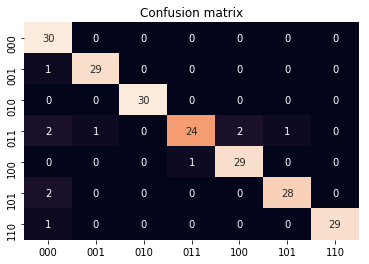

In [79]:
print("Precision: {0:6.2f}".format(precision_score(y_test, y_predict, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, y_predict, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, y_predict, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, y_predict)))
print(classification_report(y_test, y_predict))
labels = Classifier.classes_
sns.heatmap(data=confusion_matrix(y_test, y_predict), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Классификация языков по униграммам дает в среднем около 95% по всем метрикам качества. Такой высокий процент может объясняться наличием уникальных символов (букв с диакритиками) в рассматриваемых языках. По confusion matrix видно, что наиболее трудными для классификации оказываются английский язык (в нем нет уникальных символов). Лучше всего распознаются испанский и литовский. 

## По биграммам ##


* __000__ : испанский
* __001__ : португальский

* __010__ : литовский
* __100__ : польский
* __110__ : чешский 
* __011__ : английский
* __101__ : индонезийский

Precision:   0.99
Recall:   0.99
F1-measure:   0.99
Accuracy:   0.99
             precision    recall  f1-score   support

        000       1.00      1.00      1.00        30
        001       1.00      1.00      1.00        30
        010       1.00      1.00      1.00        30
        011       0.97      0.97      0.97        30
        100       0.97      0.97      0.97        30
        101       1.00      1.00      1.00        30
        110       1.00      1.00      1.00        30

avg / total       0.99      0.99      0.99       210



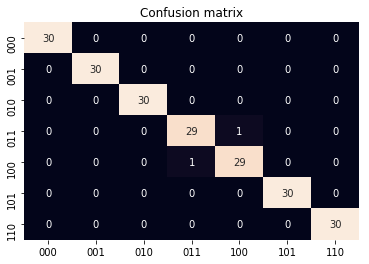

In [81]:
vect = CountVectorizer(ngram_range = [2,2], analyzer = 'char_wb', min_df = 2)

X_train = vect.fit_transform(df_train.text)
y_train = df_train['class'].values

X_test = vect.transform(df_test.text)
y_test = df_test['class'].values

Classifier = LinearSVC()
Classifier.fit(X_train, y_train)

y_predict = Classifier.predict(X_test)

print("Precision: {0:6.2f}".format(precision_score(y_test, y_predict, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, y_predict, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, y_predict, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, y_predict)))
print(classification_report(y_test, y_predict))
labels = Classifier.classes_
sns.heatmap(data=confusion_matrix(y_test, y_predict), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Классификация по биграммам дает более высокий процент для всех метрик качества - 99%.

При классификации по 3 и 4-граммам достигается самое высокое качество определения языка. 

## По триграммам ##


* __000__ : испанский
* __001__ : португальский

* __010__ : литовский
* __100__ : польский
* __110__ : чешский 
* __011__ : английский
* __101__ : индонезийский

Precision:   1.00
Recall:   1.00
F1-measure:   1.00
Accuracy:   1.00
             precision    recall  f1-score   support

        000       1.00      1.00      1.00        30
        001       1.00      1.00      1.00        30
        010       1.00      1.00      1.00        30
        011       1.00      0.97      0.98        30
        100       0.97      1.00      0.98        30
        101       1.00      1.00      1.00        30
        110       1.00      1.00      1.00        30

avg / total       1.00      1.00      1.00       210



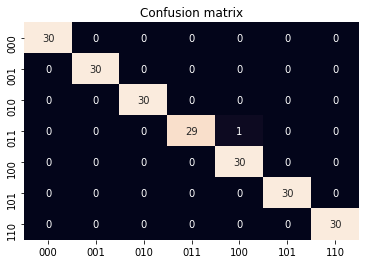

In [82]:
vect = CountVectorizer(ngram_range = [3,3], analyzer = 'char_wb', min_df = 2)

X_train = vect.fit_transform(df_train.text)
y_train = df_train['class'].values

X_test = vect.transform(df_test.text)
y_test = df_test['class'].values

Classifier = LinearSVC()
Classifier.fit(X_train, y_train)

y_predict = Classifier.predict(X_test)

print("Precision: {0:6.2f}".format(precision_score(y_test, y_predict, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, y_predict, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, y_predict, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, y_predict)))
print(classification_report(y_test, y_predict))
labels = Classifier.classes_
sns.heatmap(data=confusion_matrix(y_test, y_predict), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

## По 4-граммам ##


* __000__ : испанский
* __001__ : португальский

* __010__ : литовский
* __100__ : польский
* __110__ : чешский 
* __011__ : английский
* __101__ : индонезийский

Precision:   1.00
Recall:   1.00
F1-measure:   1.00
Accuracy:   1.00
             precision    recall  f1-score   support

        000       1.00      1.00      1.00        30
        001       1.00      1.00      1.00        30
        010       1.00      1.00      1.00        30
        011       1.00      1.00      1.00        30
        100       1.00      1.00      1.00        30
        101       1.00      1.00      1.00        30
        110       1.00      1.00      1.00        30

avg / total       1.00      1.00      1.00       210



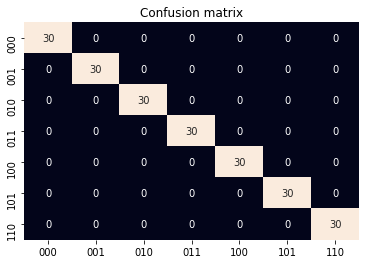

In [83]:
vect = CountVectorizer(ngram_range = [4,4], analyzer = 'char_wb', min_df = 2)

X_train = vect.fit_transform(df_train.text)
y_train = df_train['class'].values

X_test = vect.transform(df_test.text)
y_test = df_test['class'].values

Classifier = LinearSVC()
Classifier.fit(X_train, y_train)

y_predict = Classifier.predict(X_test)

print("Precision: {0:6.2f}".format(precision_score(y_test, y_predict, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, y_predict, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, y_predict, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, y_predict)))
print(classification_report(y_test, y_predict))
labels = Classifier.classes_
sns.heatmap(data=confusion_matrix(y_test, y_predict), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()